In [1]:
import numpy as np
import rasterio
from rasterio.mask import mask
import pandas as pd
import geopandas as gpd
import fiona
import os

import numpy.ma as ma # for masked arrays. This allows us to handle NAs for integer arrays

import time 

In [2]:
current_nutsid = 'PL72'

In [3]:
nuts_path = "in_data/admin/Forest_area_PL.geojson"


In [4]:
CLC_PL = 'in_data/CLC/u2018_clc2018_v2020_20u1_raster100m/DATA/PL_CLC2018_croped.tif'


In [6]:
# Extract features (polygons) from the GeoJSON file using fiona
with fiona.open(nuts_path, "r") as geojson:
    features = [feature for feature in geojson]

In [10]:

for feature in features:
    if feature['properties']['NUTS_ID'] == current_nutsid:
        break


In [45]:
#load the tif as a numpy array        
with rasterio.open(CLC_PL) as src:

    geometry = feature["geometry"]
    nutsid = feature['properties']['id']

    # Mask and crop the raster using the current polygon
    out_image, out_transform = mask(src, [geometry], invert=False, crop=True)

    affine = out_transform
    array = out_image
    array = np.squeeze(array, axis = 0)




In [33]:
# Counting the frequency of each element
unique_elements, counts = np.unique(array, return_counts=True)

# Creating a dictionary for better readability
frequency = dict(zip(unique_elements, counts))

print(frequency)

{1: 154, 2: 73536, 3: 4012, 4: 1105, 6: 69, 7: 3174, 8: 355, 9: 513, 10: 337, 11: 983, 12: 459808, 16: 24958, 18: 108750, 20: 41247, 21: 58334, 23: 39590, 24: 223372, 25: 86228, 29: 35589, 35: 1217, 36: 61, 40: 2402, 41: 5089, 48: 733301}


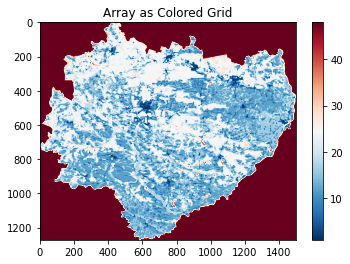

In [34]:
import matplotlib.pyplot as plt


# Plot the array
plt.imshow(array, cmap='RdBu_r')  # 'viridis' is a colormap, you can choose others like 'plasma', 'inferno', etc.
plt.colorbar()  # To show a color bar representing the scale
plt.title('Array as Colored Grid')
plt.show()


In [53]:
array_grouped = array.copy()
array_grouped[500:550,500:550]

array([[25, 25,  2, ..., 21, 21, 21],
       [25,  2,  2, ..., 21, 21, 21],
       [25,  2,  2, ..., 21, 21, 21],
       ...,
       [24, 24, 24, ..., 23, 23, 23],
       [24, 24, 24, ..., 23, 23, 23],
       [24, 24, 24, ..., 23, 23, 23]], dtype=uint8)

In [54]:
np.isin(array_grouped, group1).any()

True

In [75]:
array_grouped = array.copy()

group1 = [23, 24, 25]
group2 = [12, 13, 14, 20]
group3 = [18, 26]

replacement_value_group1 = 2
replacement_value_group2 = 1
replacement_value_group3 = 0
replacement_value_others = 4


array_grouped[np.isin(array, group1)] = replacement_value_group1

array_grouped[np.isin(array, group2)] = replacement_value_group2

array_grouped[np.isin(array, group3)] = replacement_value_group3

array_grouped[~np.isin(array, group1 + group2 + group3)] = replacement_value_others

array_grouped[np.isin(array,[48])] = 255




print(array_grouped[500:550,500:550])
print('------------')
print(array[500:550,500:550])

[[2 2 4 ... 4 4 4]
 [2 4 4 ... 4 4 4]
 [2 4 4 ... 4 4 4]
 ...
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]]
------------
[[25 25  2 ... 21 21 21]
 [25  2  2 ... 21 21 21]
 [25  2  2 ... 21 21 21]
 ...
 [24 24 24 ... 23 23 23]
 [24 24 24 ... 23 23 23]
 [24 24 24 ... 23 23 23]]


In [76]:
# Counting the frequency of each element
unique_elements, counts = np.unique(array_grouped, return_counts=True)

# Creating a dictionary for better readability
frequency = dict(zip(['grassland', 'cropland', 'forest', 'misc', 'na'], counts))

print(frequency)

{'grassland': 108750, 'cropland': 501055, 'forest': 349190, 'misc': 211888, 'na': 733301}


In [82]:
np.unique(array_grouped, return_counts=True)

(array([  0,   1,   2,   4, 255], dtype=uint8),
 array([108750, 501055, 349190, 211888, 733301]))

In [ ]:
clc      = {'grassland': 108750, 'cropland': 501055, 'forest': 349190, 'misc': 211888, 'na': 733301}
mymethod = {'grassland': 98140, 'cropland': 464080, 'forest': 339650, 'misc': 269013, 'na': 733301}

statistics = [           98140,             464080,           339650]

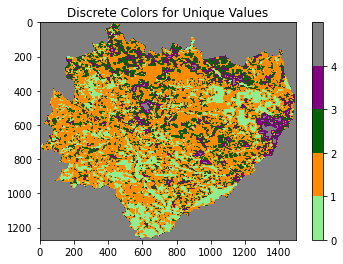

In [84]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

cmap = ListedColormap(['lightgreen', 'darkorange', 'darkgreen', 'purple', 'grey'])

# Define the boundaries that maps your data values to the colors
boundaries = [0, 1, 2, 3, 4, 256]  # Include all your unique values and an extra value for the upper edge
norm = BoundaryNorm(boundaries, cmap.N, clip=True)

# Plotting
plt.imshow(array_grouped, cmap=cmap, norm=norm)
plt.colorbar(ticks=boundaries[:-1])  # Colorbar ticks at your unique values
plt.title('Discrete Colors for Unique Values')
plt.show()
